In [96]:
import numpy as np
import tensorflow as tf
import h5py
from tensorflow import keras
from tensorflow.keras import layers, callbacks
import pandas as pd

In [97]:
latent_dim = 16
weights_file = './weights/weights.ckpt'

In [98]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def reconstruct(self, data):
        z_mean, z_log_var, z = encoder(data)
        reconstruction = decoder(z)
        return reconstruction
    
    def extract_z_values(self, data):
        return encoder(data)[2]

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(data)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [99]:
latent_dim = 16

# Encoder and Decoder declared with functional API to save all the weights together
encoder_inputs = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(64, kernel_size=4, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(128, kernel_size=4, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(512, kernel_size=4, activation="relu", strides=2, padding="same")(x)
encoded = layers.Flatten()(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(encoded)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(encoded)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 16, 16, 64)   3136        input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 8, 8, 128)    131200      conv2d_6[0][0]                   
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 4, 4, 512)    1049088     conv2d_7[0][0]                   
____________________________________________________________________________________________

In [100]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(2048)(latent_inputs)
x = layers.Reshape((4, 4, 128))(x)
x = layers.Conv2DTranspose(256, kernel_size=4, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(64, kernel_size=4, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(3, kernel_size=4, activation="relu", strides=2, padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 16)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              34816     
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 8, 8, 256)         524544    
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 16, 16, 64)        262208    
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 32, 32, 3)         3075      
Total params: 824,643
Trainable params: 824,643
Non-trainable params: 0
_____________________________________________________

In [101]:
test_file = '../data/camelyonpatch_level_2_split_test_x.h5'
test_x = h5py.File(test_file, 'r', libver='latest', swmr=True)['x']

In [102]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.load_weights(weights_file)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


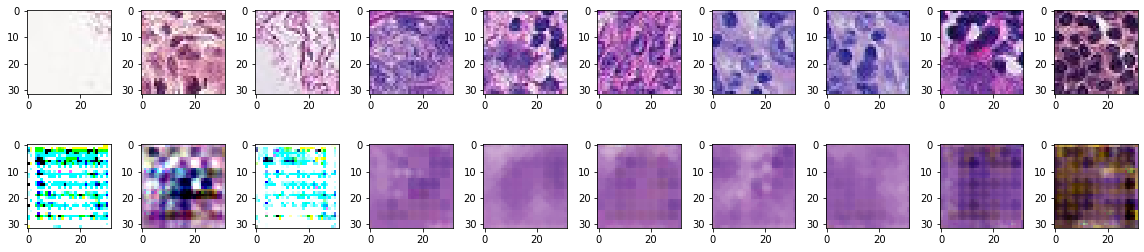

In [103]:
# display results
import matplotlib.pyplot as plt

n_rec = 10

x_batch = test_x[0:n_rec,:32,:32] / 255.

plt.figure(figsize=(n_rec+6,4))

pred_img = vae.reconstruct(x_batch)

for i in range(n_rec):
    
    plt.subplot(2, n_rec, i+1)
    plt.imshow(x_batch[i])

    plt.subplot(2, n_rec, n_rec+i+1)
    plt.imshow(pred_img[i])

plt.tight_layout()

In [110]:
# Select an example image here to mutate the latent representation
z_vals = vae.extract_z_values(test_x[7:8,:32,:32] / 255.).numpy().squeeze()

In [111]:
from ipywidgets import interact

# select the latent dim to explore 
def visualize_latent_dim(dim_number):
    n_rec = 10
    z_values = np.repeat(z_vals[:,np.newaxis], 10, axis=1).T
    z_values[:,dim_number] = np.linspace(-3,3,n_rec)
    generated = decoder(z_values)
    plt.figure(figsize=(n_rec+6,4))

    for i in range(n_rec):

        plt.subplot(1, n_rec, i+1)
        plt.imshow(generated[i])

interact(visualize_latent_dim, dim_number=(0,15));

interactive(children=(IntSlider(value=7, description='dim_number', max=15), Output()), _dom_classes=('widget-i…